## **Install package**

In [17]:
!pip install -U tensorflow

In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import glob
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
base_path = '/content/drive/My Drive/ML_Med_Prac3/Infection Segmentation Data/Infection Segmentation Data/'

In [20]:
print(f"Checking base path: {base_path}")
!ls "{base_path}"


Checking base path: /content/drive/My Drive/ML_Med_Prac3/Infection Segmentation Data/Infection Segmentation Data/
Test  Train  Val


In [21]:
def load_data_paths(base_path, category, data_type):
    images_dir = os.path.join(base_path, data_type.capitalize(), category, 'images')
    # Note the inclusion of the space in 'infection masks'
    masks_dir = os.path.join(base_path, data_type.capitalize(), category, 'infection masks')
    image_paths = [os.path.join(images_dir, filename) for filename in os.listdir(images_dir)]
    mask_paths = [os.path.join(masks_dir, filename) for filename in os.listdir(masks_dir)]
    return image_paths, mask_paths


In [22]:
def preprocess(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = image / 255.0  # Normalize to [0,1]

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [256, 256])
    mask = mask / 255.0  # Normalize to [0,1]

    return image, mask


In [23]:
def create_dataset(image_paths, mask_paths):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.batch(16).prefetch(tf.data.AUTOTUNE)


In [24]:
def build_unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)

    # Down-sampling
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)

    # Up-sampling
    u6 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(p1)
    u6 = concatenate([u6, c1])
    c6 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c6)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model


In [25]:
# Checking path
!ls "/content/drive/My Drive/ML_Med_Prac3/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19/"


 images  'infection masks'  'lung masks'


In [26]:
base_path = '/content/drive/My Drive/ML_Med_Prac3/Infection Segmentation Data/Infection Segmentation Data/'

# Load dataset paths
train_image_paths, train_mask_paths = load_data_paths(base_path, 'COVID-19', 'Train')
val_image_paths, val_mask_paths = load_data_paths(base_path, 'COVID-19', 'Val')

# Create datasets
train_dataset = create_dataset(train_image_paths, train_mask_paths)
val_dataset = create_dataset(val_image_paths, val_mask_paths)

# Build model
model = build_unet_model()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [11]:
# Train the model
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 521s 4s/step - accuracy: 0.7856 - loss: 0.5074 - val_accuracy: 0.8615 - val_loss: 0.4020
Epoch 2/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 399s 3s/step - accuracy: 0.8618 - loss: 0.3950 - val_accuracy: 0.8615 - val_loss: 0.3891
Epoch 3/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 372s 3s/step - accuracy: 0.8618 - loss: 0.3877 - val_accuracy: 0.8615 - val_loss: 0.3875
Epoch 4/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 390s 3s/step - accuracy: 0.8618 - loss: 0.3866 - val_accuracy: 0.8615 - val_loss: 0.3868
Epoch 5/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 375s 3s/step - accuracy: 0.8618 - loss: 0.3856 - val_accuracy: 0.8615 - val_loss: 0.3867
Epoch 6/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 393s 3s/step - accuracy: 0.8618 - loss: 0.3858 - val_accuracy: 0.8615 - val_loss: 0.3862
Epoch 7/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 385s 3s/step - accuracy: 0.8618 - loss: 0.3846 - val_accuracy: 0.8615 - val_loss: 0.3858
Epoch 8/10
117/117 ━━━━━━━━━━━━━━━━━━━━ 343s 3s/step - accuracy: 0.8618 - loss: 0.3849 - val_accu

In [12]:
model.save('/content/drive/My Drive/model.h5')

from tensorflow.keras.models import load_model

model = load_model('/content/drive/My Drive/model.h5')

In [13]:
from tensorflow.keras.models import load_model

# Load the model
model_path = '/content/drive/My Drive/model.h5'
model = load_model(model_path)

## **Evaluate**

In [14]:
from tensorflow.keras.models import load_model

# Load the model
model_path = '/content/drive/My Drive/model.h5'
model = load_model(model_path)

def create_dataset(image_paths, mask_paths, shuffle=True, batch_size=32):
    # Your dataset preparation steps here, ending with something like:
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

    # Apply preprocessing, assuming you have a `preprocess` function defined
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)

    # Batching occurs here
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset


In [15]:
test_image_paths, test_mask_paths = load_data_paths(base_path, 'COVID-19', 'test')
# Prepare the test dataset
test_dataset = create_dataset(test_image_paths, test_mask_paths, shuffle=False, batch_size=16)



In [16]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy)


37/37 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - accuracy: 0.8620 - loss: 0.3847
Test Loss:  0.3863708972930908
Test Accuracy:  0.8610276579856873


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


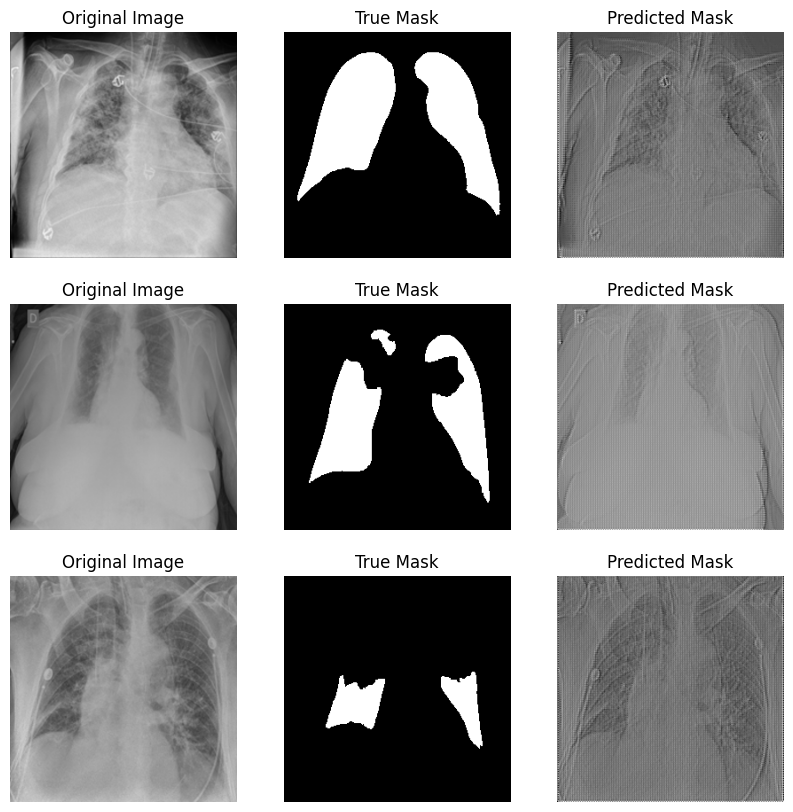

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Make predictions on a batch of test data
for test_images, test_masks in test_dataset.take(1):
    predictions = model.predict(test_images)
    plt.figure(figsize=(10, 10))
    for i in range(3):
        plt.subplot(3, 3, i*3 + 1)
        plt.imshow(test_images[i], cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(3, 3, i*3 + 2)
        plt.imshow(test_masks[i], cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        plt.subplot(3, 3, i*3 + 3)
        plt.imshow(predictions[i], cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.show()


In [28]:
from tensorflow.keras import layers, models

def build_unet_model(input_shape=(256, 256, 3)):
    inputs = layers.Input(input_shape)
    # Contraction path
    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)

    # Expansion path
    u4 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = layers.concatenate([u4, c2])
    c4 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u4)
    c4 = layers.Dropout(0.1)(c4)
    c4 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

    u5 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c1], axis=3)
    c5 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
    c5 = layers.Dropout(0.1)(c5)
    c5 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Build and compile the U-Net model
model = build_unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summarize the model
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 256, 256, 16)   │            448 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 16)   │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 128, 128, 16)   │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 128, 32)   │              0 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 64, 64, 32)     │              0 │ conv2d_9[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 64, 64, 64)     │         18,496 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64, 64, 64)     │              0 │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 64, 64, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_2        │ (None, 128, 128, 32)   │          8,224 │ conv2d_11[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 128, 128, 64)   │              0 │ conv2d_transpose_2[0]… │
│ (Concatenate)             │                        │                │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 128, 128, 32)   │         18,464 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128, 128, 32)   │              0 │ conv2d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 128, 128, 32)   │          9,248 │ dropout_3[0][0]        │
├──────────────────────

 Total params: 117,041 (457.19 KB)

 Trainable params: 117,041 (457.19 KB)

 Non-trainable params: 0 (0.00 B)